In [18]:
import torch
from torch import nn,optim
import pandas as pd
from xclip import clip
# from datasets import Dataset
from torch.utils.data import Subset, DataLoader,Dataset
from PIL import Image
import tqdm

In [19]:
torch.cuda.is_available()

True

In [20]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14']

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("RN50x4",device=device,jit=False) #Must set jit=False for training
device

'cuda:0'

In [22]:
model

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

In [23]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-base")

lmodel = AutoModelForMaskedLM.from_pretrained("Davlan/afro-xlmr-base")
lmodel

XLMRobertaForMaskedLM(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
  

In [24]:
class image_title_dataset(Dataset):
    def __init__(self, list_image_path,list_txt):

        self.image_path = list_image_path
        self.title  = clip.tokenize(list_txt) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = preprocess(Image.open('data/Images/'+self.image_path[idx])) # Image from PIL module
        title = self.title[idx]
        return image,title

In [25]:
data = pd.read_csv('data/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [26]:
# use your own data
BATCH_SIZE = 32

list_image_path = data.image.values.tolist()
list_txt = data.caption.values.tolist()
dataset = image_title_dataset(list_image_path,list_txt)
train_dataloader = DataLoader(dataset,batch_size = BATCH_SIZE) #Define your own dataloader

In [27]:
#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

In [28]:
# if device == "cpu":
#     model.float()
# else :
#     clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16
device

'cuda:0'

In [29]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset


In [30]:
# add your own code to track the training progress.
EPOCH = 3

for epoch in range(EPOCH):
    for batch in tqdm.tqdm(train_dataloader):
        optimizer.zero_grad()

        images,texts = batch 

        images= images.to(device)
        texts = texts.to(device)

        logits_per_image, logits_per_text = model(images, texts)

        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        total_loss.backward()
        # if device == "cpu":
        #      optimizer.step()
        # else : 
        #     convert_models_to_fp32(model)
        #     optimizer.step()
        #     clip.model.convert_weights(model)

100%|███████████████████████████████████████| 1265/1265 [04:40<00:00,  4.51it/s]


In [32]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"model_checkpoint/model_10.pt") #just change to your preferred folder/filename

# Explain 

In [33]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
checkpoint = torch.load("model_checkpoint/model_10.pt")

# Use these 3 lines if you use default model setting(not training setting) of the clip. For example, if you set context_length to 100 since your string is very long during training, then assign 100 to checkpoint['model_state_dict']["context_length"] 
# checkpoint['model_state_dict']["input_resolution"] = model.input_resolution #default is 224
# checkpoint['model_state_dict']["context_length"] = model.context_length # default is 77
# checkpoint['model_state_dict']["vocab_size"] = model.vocab_size 

# model.load_state_dict(checkpoint['model_state_dict'])

In [34]:
import torch
import xclip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [35]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [36]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last layer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1: 
      # calculate index of last layer 
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

In [37]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [55]:
from xclip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()


tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-base")


text_tokens=_tokenizer.encode("ሰላም እንዴት ናችሁ")
text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
text_tokens_decoded

clip.tokenize('test'),_tokenizer.encode('test')

(tensor([[49406,  1628, 49407,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0]]),
 [1628])

In [45]:


def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    print(text_scores)
    text_tokens=_tokenizer.encode(text)
    text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
    visualization.visualize_text(vis_data_records)

In [46]:
# clip.clip._MODELS = {
#     "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
#     "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
#     "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
# }

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
checkpoint = torch.load("model_checkpoint/model_10.pt")

In [48]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

tensor([0.0273, 0.0647, 0.0048, 0.1698, 0.7334], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with eye glasses


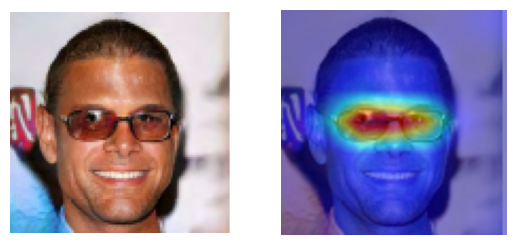

In [56]:
img_path = "data/glasses.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a man with eyeglasses"]
text = clip.tokenize(texts).to(device)
# text = _tokenizer.encode(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show()

tensor([0.2524, 0.7324, 0.0149, 0.0000], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with lipstick


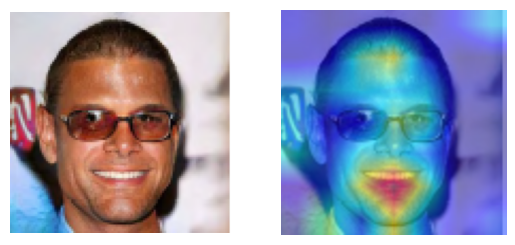

In [57]:
img_path = "data/glasses.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a man with lipstick"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show()